References Credits: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter

# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import methods_py as m
import re
import sys,time

# reload to make sure we have the latest version of method.py loaded
import importlib
importlib.reload(m)

import nltk
nltk.download(['punkt', 'wordnet','stopwords'])
from nltk.corpus import stopwords
# nltk stop word
stop_words = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_precision_recall_curve, roc_auc_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
[nltk_data] <urlopen error [Errno -3] Temporary failure in name
[nltk_data]     resolution>
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
/kaggle/input/jigsaw-toxic-comment-classifi

In [2]:
# Read in the train data 
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
# display the first 5 rows
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Explore the dataframe

In [3]:
# call custom method to explore the dataframe
m.explore_df(df)

The dataframe has  159571 rows and  8 columns 

There are  2 categorical columns and  6 numerical columns in the dataframe 

A list of all the categorical columns 

['id', 'comment_text'] 

Total number of unique values for column  id is  159571 

The first 10 unique values are ['0000997932d777bf', '000103f0d9cfb60f', '000113f07ec002fd', '00013fa6fb6ef643', '0001b41b1c6bb37e', '0001d958c54c6e35', '00024b59235015f3', '00025465d4725e87', '0002bcb3da6cb337', '0002bfc2abe2a51f']
Total number of unique values for column  comment_text is  159571 

The first 10 unique values are ["!\n\nI won't stop!  LOCK IT UP A$$HOLE", '!\n\nIt is now inside your bones, your head. Haunt you forever', "!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want people to know the TRUTH about utorrant, you FAG", "!\n\nWHY DOESN'T ANYONE BAN ME \n\nBAN ME BAN ME BAN ME BANNNNNNNNNNNNNNNNNNNNNNNNNN", '!\nPlease stop reverting my edits to Wesley Holiday, if you continue to do so you will be blocked.', "!\nWant to explain to m

In [4]:
# list of columns for the labelled comment type 
df.drop(['id','comment_text'],axis=1).columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [5]:
# adding some of the ad-hoc words coming up as frequent and I want to exclude those
stop_words.update(["u","go","as","like","wikipedia","jim","hi","get"])

# tokeinze method to remove punctuations, lemmatize and remove stop words
def tokenize(text):
    '''
    INPUT
    text- the text that needs to be tokenized
    
    OUTPUT
    tokens - a list of tokenized words after cleaning up the input text
    
    This function :
    1. converts text to all lower case and removes punctuations
    2. tokenize entire text into words
    2. lemmatize each word using WordNetLemmatizer
    3. remove all stop words from text as per english corpus of stop words
    '''
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
    
    return tokens

In [6]:
## dict(Counter(tokenize(" ".join(df[df['threat']==1].comment_text))).most_common(10)).keys()

In [7]:
print(" ###### WARNING : Comments below contain strong profanity ####### \n")

# utilizing counter to get the most common 10 words coming up in each category
for category in list(df.drop(['id','comment_text'],axis=1).columns):
    print("10 most frequent words in "+category+" comments")
    print(dict(Counter(tokenize(" ".join(df[df[category]==1].comment_text))).most_common(10)).keys())
    print("\n ********************* \n")

 ###### WARNING : Comments below contain strong profanity ####### 

10 most frequent words in toxic comments
dict_keys(['fuck', 'suck', 'shit', 'nigger', 'fucking', 'as', 'faggot', 'hate', 'page', 'know'])

 ********************* 

10 most frequent words in severe_toxic comments
dict_keys(['fuck', 'suck', 'as', 'shit', 'faggot', 'bitch', 'fucking', 'die', 'cunt', 'nigger'])

 ********************* 

10 most frequent words in obscene comments
dict_keys(['fuck', 'suck', 'shit', 'fucking', 'as', 'nigger', 'bitch', 'faggot', 'cunt', 'dick'])

 ********************* 

10 most frequent words in threat comments
dict_keys(['die', 'as', 'kill', 'going', 'block', 'fuck', 'must', 'wale', 'supertr0ll', 'fucking'])

 ********************* 

10 most frequent words in insult comments
dict_keys(['fuck', 'suck', 'nigger', 'fucking', 'faggot', 'as', 'bitch', 'fat', 'shit', 'cunt'])

 ********************* 

10 most frequent words in identity_hate comments
dict_keys(['nigger', 'jew', 'fat', 'gay', 'fuck'

In [8]:
m.explore_null(df)

The column(s) with all null values:  set() 

 More than  25 % of values are null for columns  set() 

 More than  50 % of values are null for columns  set() 

 More than  75 % of values are null for columns  set() 



Text(0.5, 0, 'category')

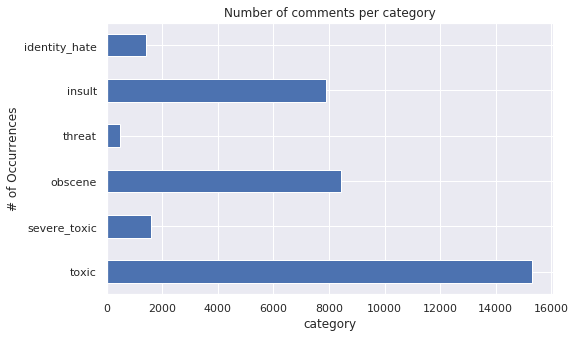

In [9]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])

df_stats.plot(x='category', y='number_of_comments', kind='barh', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

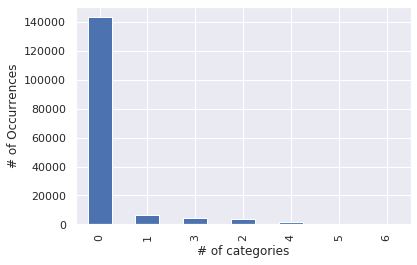

In [10]:
# How many comments have multi labels?

df.drop(['id','comment_text'],axis=1).sum(axis=1).value_counts().plot(kind='bar')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [11]:
# % of comments which are labeled

round((sum(df.drop(['id','comment_text'],axis=1).sum(axis=1) > 0)/len(df))*100,2)

10.17

This is an imbalanced set with almost 90% of comments not classified into any one of the 6 categories

Text(0.5, 0, '# of words')

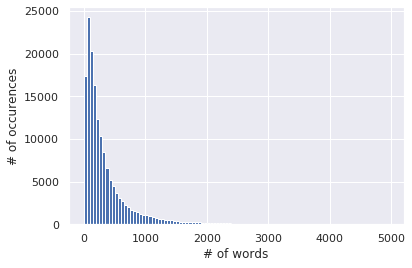

In [12]:
#The distribution of the number of words in comment texts.

lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

plt.ylabel('# of occurences', fontsize=12)
plt.xlabel('# of words', fontsize=12)

In [13]:
def build_model(model_type):
    '''
    INPUT
    None
    
    OUTPUT
    pipeline- a pipeline built to tokenize, transform and classify text data
    
    This function :
    1. builds a pipeline of countvectorizer, tfidf transformer, and
    2. a random forest multi output classifier
    '''
    if model_type == 'linear_svc':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1))
    ])
        
    elif model_type== 'naivebayes':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None)))
    ])
        
        
    elif model_type== 'logistic_reg':
        pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1))
    ])
    
    
    return pipeline

Credits: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

We consider using the ROC AUC score for evaluation the model as it is an imbalanced dataset with around 90% of comments with no labels i.e. clean comments

***Although widely used, the ROC AUC is not without problems.***

For imbalanced classification with a severe skew and few examples of the minority class, the ROC AUC can be misleading. This is because a small number of correct or incorrect predictions can result in a large change in the ROC Curve or ROC AUC score.

A common alternative is the precision-recall curve and area under curve (Precision-Recall Curves and AUC)


In [14]:
def evaluate_model(model, X_test, Y_test):
    '''
    INPUT
    model : the model that needs to be evaluated
    X_test : validation data set i.e. messages in this case
    Y_test : the output data for X_test validation set i.e. 36 categories values
    category_names : the 36 category names
    
    OUTPUT
    classification report for the model based on predictions, gives
    the recall, precision and f1 score
    
    This function :
    1. utilizes the input model to make predictions
    2. compares the predictions to the test data to provide a classification report
    '''
    
    y_pred = model.predict(X_test)
    
    # ROC AUC Score
    print(round(roc_auc_score(Y_test, y_pred),2))
    
    # Precision recall curve and AUC score
    '''
    from sklearn.calibration import CalibratedClassifierCV
    clf = CalibratedClassifierCV(model)
    clf.fit(X_train, Y_train)
    yhat = clf.predict_proba(X_test)

    model_probs = yhat[:, 1]
    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(Y_test, model_probs)
    auc_score = auc(recall, precision)
    print('PR AUC score: %.3f' % auc_score)
    # plot precision-recall curves
    #plot_pr_curve(testy, model_probs)
    '''
    

Linear SVC Model

In [15]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X= df['comment_text']

model_type = 'linear_svc'

print("Training with a "+model_type+" model")


Training with a linear_svc model


In [28]:
model_dict= dict()

for category in categories:

    print(" ---------------------------------------- ")
    print(" ROC AUC score for "+category+" comments ............")
    Y= df[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    print('Building model...')
    model = build_model(model_type)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    evaluate_model(model, X_test, Y_test)
    
    #save the model into a dictionary
    model_dict[model] = category
    print("Model saved for ",category," comments")
    

 ---------------------------------------- 
 ROC AUC score for toxic comments ............
Building model...
Training model...
Training time...2.36 minutes
Evaluating model...
0.85
Model saved for  toxic  comments
 ---------------------------------------- 
 ROC AUC score for severe_toxic comments ............
Building model...
Training model...
Training time...2.34 minutes
Evaluating model...
0.63
Model saved for  severe_toxic  comments
 ---------------------------------------- 
 ROC AUC score for obscene comments ............
Building model...
Training model...
Training time...2.35 minutes
Evaluating model...
0.85
Model saved for  obscene  comments
 ---------------------------------------- 
 ROC AUC score for threat comments ............
Building model...
Training model...
Training time...2.35 minutes
Evaluating model...
0.62
Model saved for  threat  comments
 ---------------------------------------- 
 ROC AUC score for insult comments ............
Building model...
Training model...
T

## Testing some unseen user provided input

In [105]:
comment_list= \
["==shame on you all!!!== \n\n You want to speak about gays and not about romanians...","what the hell is wrong with u","I love being here","I am going to kill this bastard",
 "fuck this entire post","you are an ignoratn bastard","are you mad","you gay idiot",
 "nigger go die somehere","get your fagget ass out","you are such a weiner pussy","like the new ideas","good things are done"]


for comment in comment_list:
    # new list
    classification_list= list()
    # switch to signify clean vs toxic comments
    switch=1
    # put the comment into a list form
    inp = [comment]
    # print the comment
    print("\n User Comment : ",comment,"\n")
    
    for model in model_dict.keys():    
        if model.predict(inp):
            classification_list.append(model_dict[model])
            switch=0
    
    if switch:
        print("CLASSIFICATION: The comment is clean and does not contain any toxicity")
    else:
        print("CLASSIFICATION: ", classification_list)


 User Comment :  ==shame on you all!!!== 

 You want to speak about gays and not about romanians... 

CLASSIFICATION:  ['toxic']

 User Comment :  what the hell is wrong with u 

CLASSIFICATION:  ['toxic']

 User Comment :  I love being here 

CLASSIFICATION: The comment is clean and does not contain any toxicity

 User Comment :  I am going to kill this bastard 

CLASSIFICATION:  ['toxic', 'obscene', 'threat', 'insult']

 User Comment :  fuck this entire post 

CLASSIFICATION:  ['toxic', 'obscene']

 User Comment :  you are an ignoratn bastard 

CLASSIFICATION:  ['toxic', 'obscene', 'insult']

 User Comment :  are you mad 

CLASSIFICATION: The comment is clean and does not contain any toxicity

 User Comment :  you gay idiot 

CLASSIFICATION:  ['toxic', 'obscene', 'insult', 'identity_hate']

 User Comment :  nigger go die somehere 

CLASSIFICATION:  ['toxic', 'threat', 'insult', 'identity_hate']

 User Comment :  get your fagget ass out 

CLASSIFICATION:  ['toxic', 'obscene', 'insult

Lets test with the test data

In [103]:
# Read in the train data 
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')
df_test = df_test.tail(20)

In [84]:
df_test_labels = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')
df_test_labels.tail(20)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153144,fff7159b3ee95618,0,0,0,0,0,0
153145,fff718ffe5f05559,0,0,0,0,0,0
153146,fff7fc22a0cdccd3,-1,-1,-1,-1,-1,-1
153147,fff83b80284d8440,0,0,0,0,0,0
153148,fff8ef316d0c6990,-1,-1,-1,-1,-1,-1
153149,fff8f521a7dbcd47,0,0,0,0,0,0
153150,fff8f64043129fa2,0,0,0,0,0,0
153151,fff9d70fe0722906,0,0,0,0,0,0
153152,fff9fa508f400ee6,-1,-1,-1,-1,-1,-1
153153,fffa3fae1890b40a,-1,-1,-1,-1,-1,-1


In [90]:
pd.set_option('display.max_colwidth',None)

df_test[df_test['id']=='fff7159b3ee95618'].comment_text

153144    == Your name mentioned == \n Hi, I just thought of letting you know that you are mentioned by Ariana310 at here and here
Name: comment_text, dtype: object

In [104]:
def classify_toxicity(text):
    
    class_list = list() 
    for model in model_dict.keys():    
        if model.predict([text]):
            class_list.append(model_dict[model])
           
    return str(class_list)

df_test['classification'] = df_test['comment_text'].apply(lambda x: classify_toxicity(x))

df_test.tail(20)

,id,comment_text,classification
153144,fff7159b3ee95618,"== Your name mentioned == \n Hi, I just thought of letting you know that you are mentioned by Ariana310 at here and here",[]
153145,fff718ffe5f05559,"I've just discovered yet another list: List of composers by name, an undifferentiated list of mostly 20th-century names. We don't need all these lists and they're impossible to maintain! There's also List of modernist composers, and List of acousmatic-music composers, as well as the more specialised List of 20th century Mexican composers and the List of female composers in the United States during the 20th century that I've mentioned before. But my favourite bizarre specialised list must be List of composers who employed pipe music.",[]
153146,fff7fc22a0cdccd3,"==Wikiproject Video Games assessment== \n I don't have a lot to say here. The content looks much better, but given that it only has two references this will have to remain Start class. I'd say it needs at least 10 reliable sources before we can bump it to C class.",[]
153147,fff83b80284d8440,::Consensus for ruining Wikipedia? I think that can be ignored.,[]
153148,fff8ef316d0c6990,"== DAP ? == \n\n What's point with DAP ?! Nazism isn't socialism. It's only the name \n *Not class struggle, which is an important socialism topic",[]
153149,fff8f521a7dbcd47,shut down the mexican border withought looking bad.,['toxic']
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! I’m not surprised: I looked for an example of the ‘’in nomine’’ plainsong notaion and couldn’t find one online - to my astonishment too. \n :But maybe you could clear up a question for me: is the cantus firmus of the English ‘’in nomines’’ the plainchant (in the alto part), or one of Taverner’s other three parts? This is not clear to me in the article. If the ‘’in nomines’’ are based on the plainchant, then where does Taverner come into it? Your expertise would be most appreciated, and maybe the article requires some explanation to this effect.",[]
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundation.org/wiki/Press_releases/English_Wikipedia_Announces_Thousandth_Featured_Article \n\n Heh you are famous now. I kida envy that. Congrats.,['toxic']
153152,fff9fa508f400ee6,==WTF== \n It's no longer a redlink. Now what's the problem?,['toxic']
153153,fffa3fae1890b40a,""" \n\n ==""""Illness"""" no shit== \n Just for the record, you can die of a stroke, a heart attack, internal bleeding, injuries sustained in a car accident, homicide, suicide and a host of other causes that aren't illnesses, so it's not immediately obvious, especially for a man who is only 56 years old you ass. If that's all the reference says at the time, that's all I can work with. """,['toxic']


In [ ]:
df_test.head(20)

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X= df['comment_text']

# model_type in ['linear_svc','naivebayes','logistic_reg']

model_type = 'linear_svc'

print("Training with a "+model_type+" model")
for category in categories:
    print(" ---------------------------------------- ")
    print(" Precision and recall score for "+category+" comments ............")
    Y= df[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    print('Building model...')
    model = build_model(model_type)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    evaluate_model(model, X_test, Y_test)

Naive Bayes Classifier

model_type = 'naivebayes'

print("Training with a "+model_type+" model")
for category in categories:
    print(" ---------------------------------------- ")
    print(" Precision and recall score for "+category+" comments ............")
    Y= df[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    print('Building model...')
    model = build_model(model_type)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    evaluate_model(model, X_test, Y_test)

Logistic Regression

model_type = 'logistic_reg'

print("Training with a "+model_type+" model")
for category in categories:
    print(" ---------------------------------------- ")
    print(" Precision and recall score for "+category+" comments ............")
    Y= df[category]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    print('Building model...')
    model = build_model(model_type)

    print('Training model...')
    start_time = time.time()
    model.fit(X_train, Y_train)
    elapsed_time = round((time.time() - start_time)/60 , 2)
    print('Training time...{} minutes'.format(elapsed_time))

    print('Evaluating model...')
    evaluate_model(model, X_test, Y_test)

Conclusion:

Overall, the Linear SVC model has a better overall score amongst the three models.